<center>
  <h1>
      FineTuneSDwithLora
  </h1>
</center>

## Stable Diffusion
When you provide a text prompt to Stable Diffusion, the following steps occur:

* The text prompt is fed into the Text Encoder, which converts it into a latent text embedding.
* A random noise tensor is generated in the latent space. This serves as the starting point for the image.
* The U-Net takes the noisy latent tensor and the text embedding as input. Based on its training, it predicts the noise present in the latent tensor that should be removed.
* A scheduler (a component that manages the denoising steps) uses the predicted noise to slightly denoise the latent tensor.
* Steps 3 and 4 are repeated iteratively for a set number of steps (typically between 20 and 50). With each step, the latent representation becomes progressively less noisy and closer to a coherent image guided by the text embedding.
* Finally, the denoised latent tensor is passed to the VAE Decoder, which reconstructs it into the final high-resolution pixel image that you see.

By working in the compressed latent space and employing this iterative denoising process guided by text, Stable Diffusion efficiently and effectively translates linguistic descriptions into a vast array of creative and often stunning visual output

## LoRA
LoRA operates on the principle that the updates to the weights of a large pre-trained model during fine-tuning have a low "intrinsic rank." Instead of training the entire weight matrix of a layer, LoRA introduces two smaller matrices (learnable low-rank decomposition matrices) that, when multiplied, approximate the desired update to the original weight matrix.


In [ ]:
# @title 1. Setup Environment and Install Libraries
# ---

# Install libraries, explicitly pinning torch to a compatible version
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 -q
!pip install -q transformers accelerate bitsandbytes ftfy xformers peft Pillow
# Clone the diffusers repository and install from source
!git clone https://github.com/huggingface/diffusers.git
!pip install -q ./diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.0/867.0 MB 770.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
# @title 2. Define Parameters and Prepare Data
# ---
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image
import os

# ---  Training Settings ---
base_model_id = "runwayml/stable-diffusion-v1-5"
instance_token = "sks_person"
training_images_dir = "/content/images"
output_dir = "/content/output_lora"

resolution = 512 # as we are using SD 1.5
train_batch_size = 1
gradient_accumulation_steps = 1
learning_rate = 1e-4
lr_scheduler = "constant" # Options: linear, cosine, constant, etc.
lr_warmup_steps = 0
max_train_steps = 800
seed = 42

# --- Internal Setup ---
instance_prompt = f"a photo of {instance_token}"
images_folder_name = "instance_images"

# --- Data Preparation ---
# Create directories
os.makedirs(output_dir, exist_ok=True)


# --- Create a metadata file (needed by some training scripts/pipelines) ---
# This tells the trainer what prompt corresponds to the images in the folder
import json
metadata_content = [{"image_path": f, "caption": instance_prompt} for f in os.listdir(training_images_dir)]
metadata_file_path = os.path.join(output_dir, "metadata.jsonl") # Note the 'l' for json lines format
with open(metadata_file_path, 'w') as f:
    for item in metadata_content:
        f.write(json.dumps(item) + "\n")
print(f"Metadata file created at: {metadata_file_path}")


Metadata file created at: /content/output_lora/metadata.jsonl


In [ ]:
# @title 3. Run LoRA Training (using Accelerate and Diffusers Script)
# Download the training script from diffusers examples
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

train_script = "train_dreambooth_lora.py"


accelerate_cmd = f"""
accelerate launch {train_script} \
  --pretrained_model_name_or_path="{base_model_id}" \
  --instance_data_dir={training_images_dir} \
  --instance_prompt="{instance_prompt}" \
  --output_dir="{output_dir}" \
  --seed={seed} \
  --resolution={resolution} \
  --train_batch_size={train_batch_size} \
  --gradient_accumulation_steps={gradient_accumulation_steps} \
  --gradient_checkpointing \
  --learning_rate={learning_rate} \
  --lr_scheduler="{lr_scheduler}" \
  --lr_warmup_steps={lr_warmup_steps} \
  --max_train_steps={max_train_steps} \
  --validation_prompt="{instance_prompt}" \
  --validation_epochs=50 \
  --report_to="tensorboard" \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention
"""


# Execute the training command
!{accelerate_cmd}

# The LoRA weights are typically saved as 'pytorch_lora_weights.safetensors' or '.bin'
lora_weights_path = os.path.join(output_dir, "pytorch_lora_weights.safetensors")
if not os.path.exists(lora_weights_path):
     lora_weights_path = os.path.join(output_dir, "pytorch_lora_weights.bin") # Fallback check

if os.path.exists(lora_weights_path):
    print(f"Found LoRA weights: {lora_weights_path}")
else:
    print("ERROR: LoRA weights file not found in the output directory. Check training logs.")



The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-05-07 16:34:58.262309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746635698.296903    2144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746635698.306866    2144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
05/07/2025 16:35:03 - INFO - __main__ - Distributed en

Loading base model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n


Generating images...

Generating image 1/4:
  Prompt: sks_person
  Negative Prompt: photorealistic, photograph, deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry, (((mutated hands and fingers))), watermark, signature, text, words, username


  0%|          | 0/30 [00:00<?, ?it/s]

  Saved image: /content/generated_images/output_1_1_sks_person.png

Generating image 2/4:
  Prompt: watercolor painting of sks_person in a spacesuit, detailed, artstation, make sks_person face shown
  Negative Prompt: photorealistic, photograph, deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry, (((mutated hands and fingers))), watermark, signature, text, words, username


  0%|          | 0/30 [00:00<?, ?it/s]

  Saved image: /content/generated_images/output_2_1_watercolor_painting_of_sks_person_in_a_spacesuit__.png

Generating image 3/4:
  Prompt: watercolor painting of a woman sks_person riding a horse through a field, sunny day, brush strokes 
  Negative Prompt: photorealistic, photograph, deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry, (((mutated hands and fingers))), watermark, signature, text, words, username


  0%|          | 0/30 [00:00<?, ?it/s]

  Saved image: /content/generated_images/output_3_1_watercolor_painting_of_a_woman_sks_person_riding_a.png

Generating image 4/4:
  Prompt: watercolor painting style, a woman sks_person playing cricket, action shot, stadium background
  Negative Prompt: photorealistic, photograph, deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry, (((mutated hands and fingers))), watermark, signature, text, words, username


  0%|          | 0/30 [00:00<?, ?it/s]

  Saved image: /content/generated_images/output_4_1_watercolor_painting_style__a_woman_sks_person_play.png

Image generation complete.
Generated images saved in: /content/generated_images


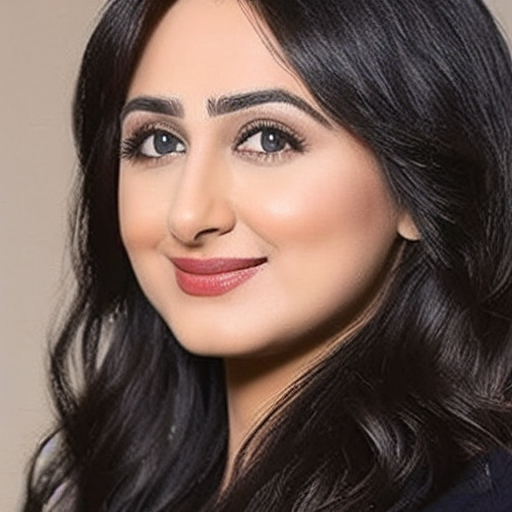

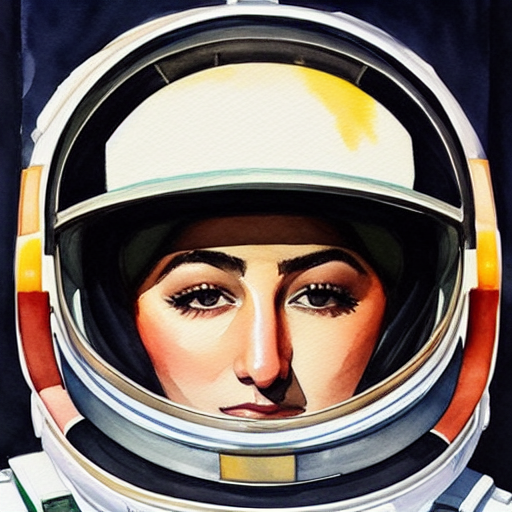

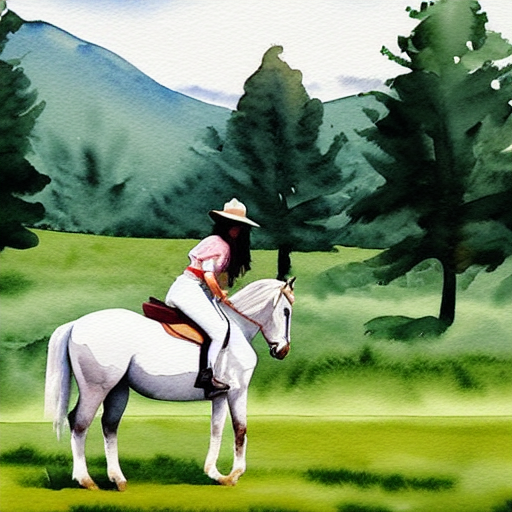

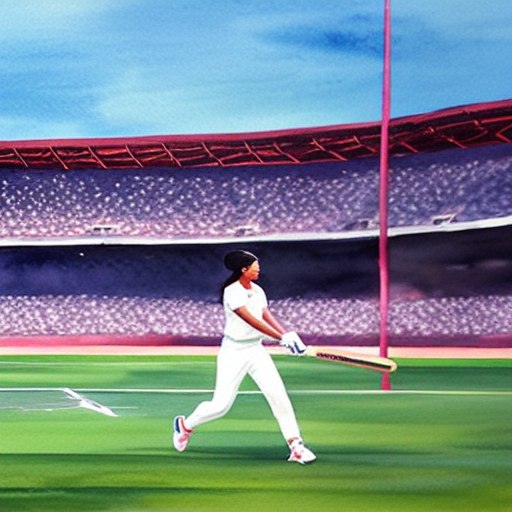

In [ ]:
# @title 4. Inference: Generate Images using the Trained LoRA
# ---


# --- Parameters ---
base_model_id = "runwayml/stable-diffusion-v1-5" # Use the SAME base model used for training

lora_weights_path = os.path.join(output_dir, "pytorch_lora_weights.safetensors") # Path to trained LoRA weights file
if not os.path.exists(lora_weights_path):
     lora_weights_path = os.path.join(output_dir, "pytorch_lora_weights.bin")

instance_token = "sks_person" # our instance_token

# Output directory for generated images
generated_images_dir = "/content/generated_images"
os.makedirs(generated_images_dir, exist_ok=True)

# --- Load Pipeline ---
print("Loading base model...")
pipe = DiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16, # Use float16 for faster inference & less memory
    safety_checker=None # Disable safety checker if needed
)

# Configure scheduler for potentially better quality/speed
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Load LoRA weights into the pipeline
pipe.load_lora_weights(output_dir, weight_name=os.path.basename(lora_weights_path), adapter_name="face")
# Move pipeline to GPU
pipe.to("cuda")



# --- Define Prompts and Parameters ---
prompts = [
    f"{instance_token}",
    f"watercolor painting of {instance_token} in a spacesuit, detailed, artstation, make {instance_token} face shown",
    f"watercolor painting of a woman {instance_token} riding a horse through a field, sunny day, brush strokes ",
    f"watercolor painting style, a woman {instance_token} playing cricket, action shot, stadium background",
]

negative_prompt = "photorealistic, photograph, deformed, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blurry, (((mutated hands and fingers))), watermark, signature, text, words, username"

# Inference parameters
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5    # How strongly the prompt guides generation (CFG scale)
num_images_per_prompt = 1
generator = torch.Generator("cuda").manual_seed(seed) # for reproducible results

# --- Generate Images ---
print("\nGenerating images...")
output_image_paths = []
for i, prompt in enumerate(prompts):
    print(f"\nGenerating image {i+1}/{len(prompts)}:")
    print(f"  Prompt: {prompt}")
    print(f"  Negative Prompt: {negative_prompt}")

    # We can control the *strength* of the LoRA using `cross_attention_kwargs={"scale": lora_scale}`
    # where lora_scale is a float (e.g., 0.7). Default is 1.0.
    images = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        num_images_per_prompt=num_images_per_prompt,
        generator=generator,
        cross_attention_kwargs={"scale": 0.8} #  LoRA strength (0.0 to 1.0+)
    ).images

    # Save the generated image(s)
    for j, img in enumerate(images):
        safe_prompt = "".join(c if c.isalnum() else "_" for c in prompt[:50])
        filename = f"output_{i+1}_{j+1}_{safe_prompt}.png"
        img_path = os.path.join(generated_images_dir, filename)
        img.save(img_path)
        output_image_paths.append(img_path)
        print(f"  Saved image: {img_path}")

print("\nImage generation complete.")
print(f"Generated images saved in: {generated_images_dir}")

# Display generated images (optional, works well in Colab)
from IPython.display import display
for img_path in output_image_paths:
     display(Image.open(img_path))